In [671]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, make_scorer, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from analysis_lib.manager import DataManager

import itertools 
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, LeaveOneOut

import matplotlib

from scipy.stats import pearsonr
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [667]:
matplotlib.rcParams.update({'font.size': 16})

In [828]:
linestyles = {
    "Random forest": "-",
    "SVM": "-.",
    "Logistic regression": "--"
}

def gen_params_grid(y):
    balanced_weight_dict = {}
    for class_name, class_weight in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y),y=y)):
        balanced_weight_dict[class_name] = round(class_weight, 2)

    class_weight_selection = [{1:h_w, 0:l_w} \
                                                 for h_w, l_w in itertools.product([1,4,8] , [0.25,1])
                                                 ]
    class_weight_selection.append(balanced_weight_dict)

    svm_param_grid = {'kernel':['linear'],
                      'C':[ 0.1, 0.5, 1., 5., 10., 20, 50.],
                      'class_weight': class_weight_selection,
                      "probability": [True],
                      'random_state':[42],
    }
    rf_param_grid = {
        'random_state':[42],
        'criterion':['gini'],
        'max_features': ['sqrt'],
        'n_estimators': [ 100 ],
        'max_depth': list(range(2, 11)) + [None],
        'class_weight': class_weight_selection
    #     'model__min_samples_leaf': [1,2,3, 5],
        }
    log_reg_param_grid = {
        'penalty':['l1','l2','none'],
        'C':[ 0.1, 0.5, 1., 5., 10., 20, 50.],
        'solver':['liblinear'],
        'class_weight': class_weight_selection,
        'random_state':[42],
    }

    models_list = [RandomForestClassifier(), 
                   SVC(),
                   LogisticRegression()]
    params_list = [rf_param_grid, svm_param_grid, log_reg_param_grid]

    model_names_list = ["Random forest", "SVM", "Logistic regression"]

    return models_list, params_list, model_names_list

In [ ]:
models = {}
random_state = 42
smote = SMOTE(k_neighbors=6, sampling_strategy=1., random_state=random_state)

scorer = make_scorer(f1_score, pos_label=1)
n_splits = 5

In [ ]:
anomalous_nuts = ["FI20","ES64", "FRY5","ES63","BG32", "BG42"] 
nuts2_to_remove_scandinavia = ['SE11', 'SE12', 'SE21', 'SE22', 'SE23', 'SE31', 'SE32', 'SE33']
NUTS_to_remove =  anomalous_nuts + nuts2_to_remove_scandinavia 

dates = {
    1: ("2020-02-20", "2020-08-20"),
    2: ("2020-08-20", "2021-02-20")
}

scores = {
    1: {},
    2: {}
}

n_clusters = 2
clust_method='ML'
prob_type = "classification"


for wave in [1,2]:
    print("Wave", wave)
    start_date, end_date = dates[wave]

    dm = DataManager(start_date=start_date,
                            end_date=end_date,
                                n_clusters=n_clusters,
                                clust_method="ML",
    #                              threshold=0.00625,
                             nuts2_to_remove=NUTS_to_remove,
                            sqlite_file_path="covid_at_lombardy.sqlite",
                            clf_type="binary",
                             prob_type="classification",
                             response="cumulativepositive") 


    df, y = dm.get_dataset()

    X = df.values
    y = (y.values == "higher_than_avg").astype(int)
    
    models_list, params_list, model_names_list = gen_params_grid(y)
    
    print("positive y #", y.sum())
    
    fig, ax = plt.subplots(figsize=(8,8))

    x = np.linspace(0,1,10)
    ax.plot(x, x, linestyle=':')
    
    models[wave] = {}

    for model, name, params in zip(models_list, model_names_list, params_list):
        print(name)

        pipe = Pipeline([('resample', smote), ('model', model)])

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        gs = GridSearchCV(pipe, param_grid={ f"model__{k}":v for k,v in params.items() }, cv=kf, scoring=scorer, n_jobs=-1, verbose=1)
        gs.fit(X, y)

        best_pipe = gs.best_estimator_

        loo = LeaveOneOut()
        y_pred = cross_val_predict(best_pipe, X, y, cv=loo, n_jobs=-1, method="predict_proba")
        y_pred_labels = cross_val_predict(best_pipe, X, y, cv=loo, n_jobs=-1)
        
        scores[wave][name] = {
            "f1": round(f1_score(y, y_pred_labels, pos_label=1), 4),
            "precision": round(precision_score(y, y_pred_labels, pos_label=1), 4),
            "recall": round(recall_score(y, y_pred_labels, pos_label=1), 4),
        }
        print(scores[wave][name])
        
        auc = roc_auc_score(y, y_pred[:,1])

        fpr, tpr, thresholds = roc_curve(y, y_pred[:,1], pos_label=1)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {round(roc_auc_score(y, y_pred[:,1]), 4)})", linestyle=linestyles[name])

        best_pipe.fit(X, y)
        models[wave][name] = best_pipe["model"]

    ax.legend(loc="lower right")
    ax.grid()
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    fig.savefig(f"roc-{wave}.pdf", bbox_inches="tight")

In [822]:
def get_values(model):
    if type(model).__name__ == "RandomForestClassifier":
        weights = model.feature_importances_
    else:
        weights = abs(model.coef_[0])
    return weights

In [762]:
cp = pd.MultiIndex.from_tuples(list(product([1,2], model_names_list[::-1])))
df_corr = pd.DataFrame(index=cp, columns=cp)

for wave1, model1 in cp:
    for wave2, model2 in cp:
        corr, pval = pearsonr(get_values(models[wave1][model1]), get_values(models[wave2][model2]))
        
        if pval >= 0.05:
            corr = f"n.s."
        else:
            corr = round(corr, 4)
        df_corr.loc[(wave1, model1), (wave2, model2)] = corr

In [763]:
df_corr

1                        \
                      Logistic regression     SVM Random forest   
1 Logistic regression                   1  0.8917          n.s.   
  SVM                              0.8917       1        0.5065   
  Random forest                      n.s.  0.5065             1   
2 Logistic regression              0.8423  0.5876          n.s.   
  SVM                              0.5919  0.4938          n.s.   
  Random forest                      n.s.    n.s.        0.4585   

                                        2                        
                      Logistic regression     SVM Random forest  
1 Logistic regression              0.8423  0.5919          n.s.  
  SVM                              0.5876  0.4938          n.s.  
  Random forest                      n.s.    n.s.        0.4585  
2 Logistic regression                   1  0.7834          n.s.  
  SVM                              0.7834       1          n.s.  
  Random forest                      n.s.    n.s.             1

In [675]:
import seaborn as sns

In [725]:
def plot_coefs(model):
    if type(model).__name__ == "RandomForestClassifier":
        coefs = model.feature_importances_
        coefs_name = "feature importance"
        palette_name = "Greys_r"
    else:
        coefs = model.coef_[0]
        coefs_name = "coefficient"
        palette_name = "RdBu"
    
    df_coef = pd.DataFrame(data=np.vstack([coefs, df.columns]).T, columns=[coefs_name, "feature"])

    a = df_coef[coefs_name][abs(df_coef[coefs_name]).argsort()[::-1]]

    pal = sns.color_palette(palette_name, len(a))
    hue = [ pal[i] for i in a.argsort()[::-1].argsort() ]

    fig, ax = plt.subplots(figsize=(6,6))
    sns.barplot(data=df_coef, x=coefs_name, y="feature", palette=hue, order=df_coef.iloc[abs(df_coef[coefs_name]).argsort()[::-1]].feature, ax=ax)
    ax.set_axisbelow(True)
    ax.grid(axis='y', alpha=.5)
    ax.set_ylabel("")
    
    return fig, ax

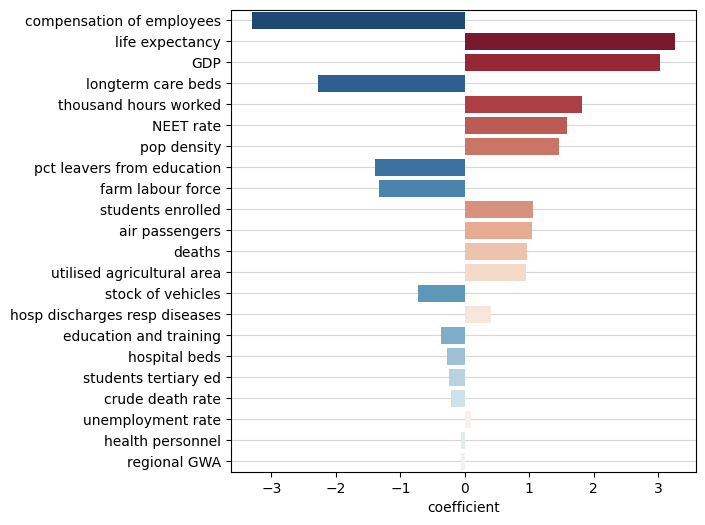

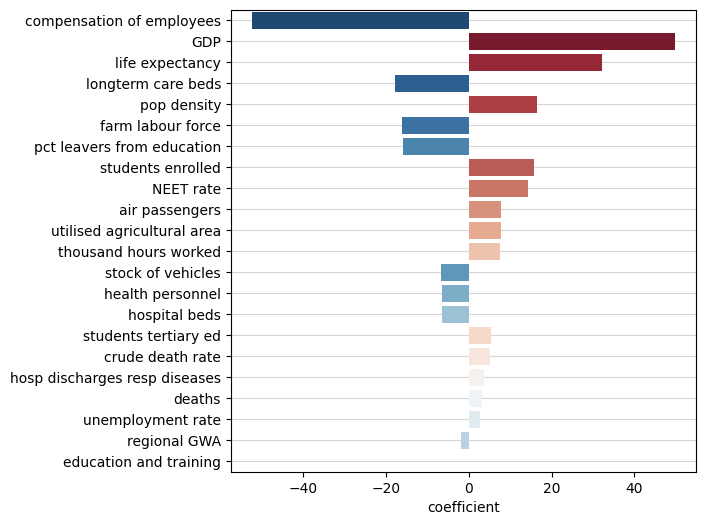

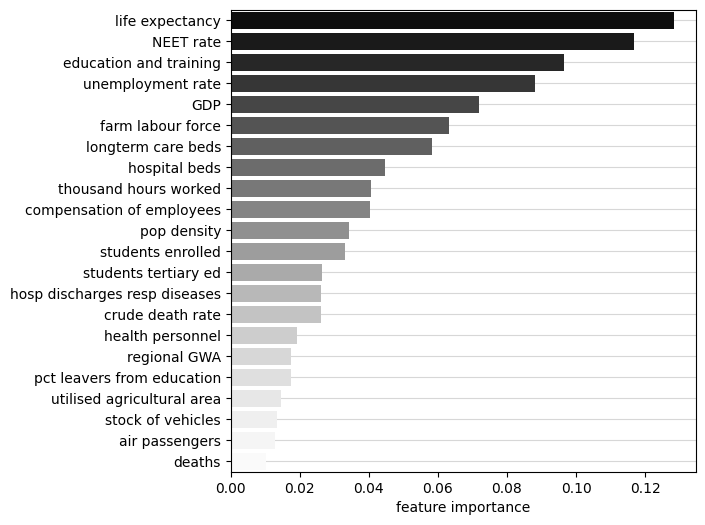

In [726]:
fig, ax = plot_coefs(models[1]["SVM"])
fig.savefig("coef-wave1-svm.pdf", bbox_inches="tight")
fig, ax = plot_coefs(models[1]["Logistic regression"])
fig.savefig("coef-wave1-lr.pdf", bbox_inches="tight")
fig, ax = plot_coefs(models[1]["Random forest"])
fig.savefig("coef-wave1-rf.pdf", bbox_inches="tight")

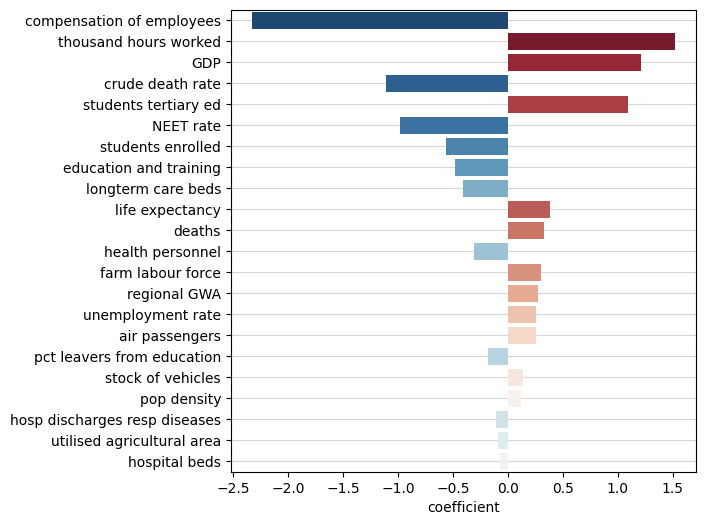

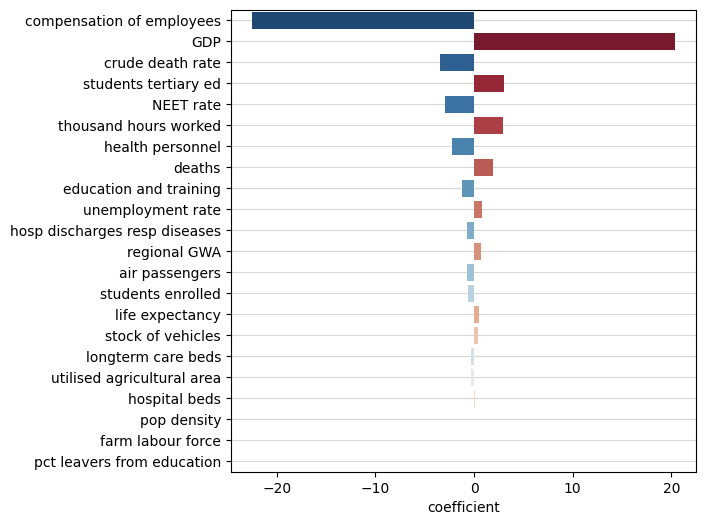

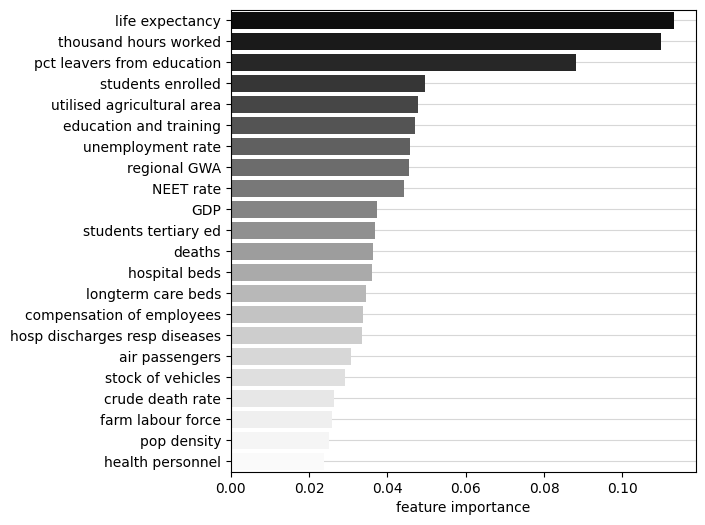

In [727]:
fig, ax = plot_coefs(models[2]["SVM"])
fig.savefig("coef-wave2-svm.pdf", bbox_inches="tight")
fig, ax = plot_coefs(models[2]["Logistic regression"])
fig.savefig("coef-wave2-lr.pdf", bbox_inches="tight")
fig, ax = plot_coefs(models[2]["Random forest"])
fig.savefig("coef-wave2-rf.pdf", bbox_inches="tight")